ABANDONED
=========

Preliminary tests showed no interesting results
-----------------------------------------------

In [1]:
import pandas as pd
import mapply
mapply.init(n_workers=5, progressbar=True)

/home/hlt/HLT_PROJECT/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import pipeline

# classifier = pipeline("zero-shot-classification", "facebook/bart-large-mnli", device="cuda:0")
classifier = pipeline("zero-shot-classification", "cross-encoder/nli-distilroberta-base", device="cuda:0")
# classifier = pipeline("zero-shot-classification", "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli", device="cuda:0")

In [3]:
# Test with only the name and artist

song = "Cotton Eye Joe"
artist = "Rednex"

text = f"The genre of the song <{song}> by <{artist}> is:"
candidates = ["pop", "rap", "rock", "rythm-blues", "country"]

classifier(text, candidates)

{'sequence': 'The genre of the song <Cotton Eye Joe> by <Rednex> is:',
 'labels': ['rythm-blues', 'pop', 'country', 'rock', 'rap'],
 'scores': [0.25857576727867126,
  0.23048096895217896,
  0.221792072057724,
  0.18515253067016602,
  0.10399868339300156]}

In [4]:
clear = pd.read_feather('../data/lyrics_cleaned.feather')
clear = clear[clear['tag'] != 'misc']

clear['TAG'] = clear['tag']

In [11]:
song = clear.sample(n=1).iloc[0]

lyrics = song['lyrics_clean']

# prompt = f"Artist: {song['artist']}\nTitle: {song['title']}\nLyrics: {lyrics}\nThe genre of this song is: "
prompt = f"Predict the genre of the song from the lyrics;\n{lyrics} -> "
candidates = ["Pop", "Rap", "Rock", "Rythm&Blues", "Country"]

pred = classifier(prompt, candidates)

print(song['title'])
print(song['artist'])
print(song['TAG'])
print(prompt[:200])
print(pred['labels'], pred['scores'])

In the Dark
YG
rap
Predict the genre of the song from the lyrics;

Mustard on the beat, ho


I'm in the dark goin' brazy
I'm in the dark throwin' twenty past eighty
I'm in the dark, it's a movie, Scorsese
I'm in the dar
['Rap', 'Pop', 'Rock', 'Country', 'Rythm&Blues'] [0.24872754514217377, 0.24742549657821655, 0.19014227390289307, 0.1697729229927063, 0.14393173158168793]


100%|██████████| 1/1 [00:00<00:00, 557.90it/s]

              precision    recall  f1-score   support

        rock       0.27      0.22      0.24        32
          rb       0.67      0.06      0.11        32
         pop       0.17      0.19      0.18        32
         rap       0.23      0.09      0.13        32
     country       0.22      0.56      0.31        32

    accuracy                           0.23       160
   macro avg       0.31      0.23      0.20       160
weighted avg       0.31      0.23      0.20       160



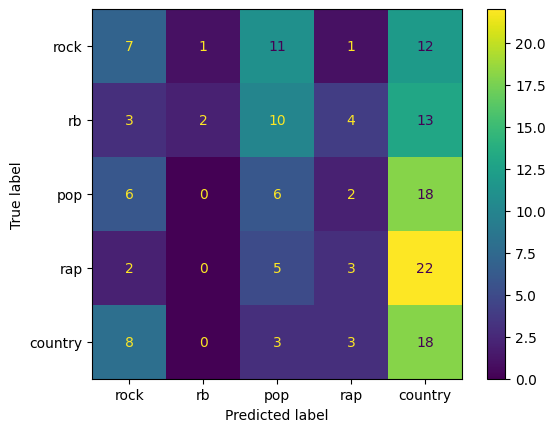

In [7]:
N = 32
sample = []

for tag in clear['TAG'].unique():
  s = clear[clear['TAG'] == tag].sample(n=N)
  sample += [s]

sample = pd.concat(sample)

true = sample['TAG'].to_list()

GENRE = {
  'rock': "Rock",
  'rb': "Blues",
  'pop': "Pop",
  'rap': "Rap",
  'country': "Country",
}
GENRE_1 = {v:k for k, v in GENRE.items()}
CANDIDATES = list(GENRE.values())
CANDIDATES_1 = list(GENRE_1.values())

def gen_prompt(song):
  lyrics = song['lyrics_clean'].replace('\n', ' ')
  title = song['title']
  artist = song['artist']
  # return f"Predict the genre of the song from the title and artist;\n{title}\n{artist} -> "
  return f"{lyrics}\nThe genre of this song is "
  # return f"Predict the genre of the song from the lyrics, song title and artist;\n{lyrics}\n{title}\n{artist} -> "
  
prompts = sample.mapply(gen_prompt, axis=1).to_list()

results = classifier(prompts, CANDIDATES)

pred = [GENRE_1[r['labels'][0]] for r in results]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix(true, pred, labels=CANDIDATES_1), display_labels=CANDIDATES_1)

disp.plot()

print(classification_report(true, pred, labels=CANDIDATES_1))